In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
hf = r'../outputs/3.2_central_place_analysis/'
os.makedirs(hf, exist_ok=True)

# 3.2 Central Place Analysis

The chapter Student Housing Market: Capacities, Demand, and Spatial Distribution provides a consistent analysis of two systems: student accommodations and higher education universities. 

To proceed to market analysis, it is necessary to examine how these two systems interact with each other, forming the student accommodation market. Central Place Theory, outlined in the chapter Theoretical Framework, assists in navigating the analysis process.

### Set Up 

Import Libraries 

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
from pyproj import CRS
from scipy.stats import norm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects
import string
import requests
import time
from shapely.geometry import Polygon
import seaborn as sns
from shapely.geometry import MultiPolygon

Colors

In [3]:
color_palettes = {
    "Mint": ["#EAF4E8", "#C8E0D4", "#A9CCC1", "#8FB9AE", "#76A79D", "#5F968E", "#498581"], 
    "Pi": ["#F8EDEB", "#FAE1DD", "#FCD5CE", "#FEC5BB", "#F8AD9D", "#F4978E", "#F08080"],
    "Or": ["#FFE5D9", "#FFD7BA", "#FEC89A", "#FFB78F", "#F49F7D", "#F28B6D", "#E1755CFF"],
    "GrSc":  ['#EFEFEF', '#D9D9D9', '#CCCCCC', '#B7B7B7', '#999999', '#666666', '#434343'],
    "MintPi": ["#76A79D", "#8FB9AE", "#A9CCC1", "#C8E0D4", "#FBF0EA", "#FCD5CE", "#FEC5BB", "#F8AD9D", "#F4978E"],
    "MintOr": ["#76A79D", "#8FB9AE", "#A9CCC1", "#C8E0D4", "#FBF0EA", "#FFD7BA", "#FEC89A", "#FFB78F", "#F28B6D"],
    "MiPiOr": ['#EAF4E8', '#FAE1DD', '#C8E0D4', '#FFD7BA', '#F8EDEB', '#FCD5CE', '#FFE5D9']
}

cmap_mint = LinearSegmentedColormap.from_list("Mint", color_palettes["Mint"])
cmap_pi = LinearSegmentedColormap.from_list("Pi", color_palettes["Pi"])
cmap_or = LinearSegmentedColormap.from_list("Or", color_palettes["Or"])
cmap_mintpi = LinearSegmentedColormap.from_list("MintPi", color_palettes["MintPi"])
cmap_mintor = LinearSegmentedColormap.from_list("MintOr", color_palettes["MintOr"])
cmap_grsc = LinearSegmentedColormap.from_list("GrSc", color_palettes["GrSc"])
cmap_mipior = LinearSegmentedColormap.from_list("MiPiOr", color_palettes["MiPiOr"])

Font

In [4]:
plt.rcParams["font.family"] = "Helvetica"

Berlin Spatial Boundaries

In [5]:
pf = r"../inputs/3.2_central_place_analysis/lor_pgr.gpkg"
pgr = gpd.read_file(pf)
pgr.replace({'-': np.nan, 0: np.nan, '': np.nan}, inplace=True)

bf = r"../inputs/3.2_central_place_analysis/adm_bz.gpkg"
bz = gpd.read_file(bf)
bz.replace({'-': np.nan, 0: np.nan, '': np.nan}, inplace=True)

of = r"../inputs/3.2_central_place_analysis/adm_out.gpkg"
out = gpd.read_file(of)
out.replace({'-': np.nan, 0: np.nan, '': np.nan}, inplace=True)

The analysis of student accommodation capacity and higher education universities' international student demand data, obtained as a result of Global Spatial Autocorrelation, served as the basis for student housing market research. 

In [6]:
ef = r'../inputs/3.2_central_place_analysis/pbsa_capacity_analysis.gpkg'
pbsa_cap = gpd.read_file(ef)

mf = r'../inputs/3.2_central_place_analysis/uni_int_demand_analysis.gpkg'
uni_dem = gpd.read_file(mf, driver="GPKG")

# Central Places Definition

In Central Place Theory King (1986) argue that the idea that there is a smooth and regular progression in urban centres from the smallest up to the largest center - is not a very useful one, and that greater insight can be gained into the nature of an urban pattern by referring to discrete population-size classes. 

Taking this into account, central universities should be defined not as the ‘largest’ in terms of numbers, but as institutions that perform central functions in the urban system. Their significance is determined not so much by the scale of student enrolment as by their functional role, their position in the urban and educational hierarchy, and their ability to serve wider areas of attraction.

Cleaning Higher Education Universities Data Set

In [7]:
uni_dem = uni_dem.dropna(subset=['!s_aus'])

uni_dem = uni_dem.drop(columns=['!s_aus_std', '!s_aus_slag', '!s_aus_slag_std'])

In order to determine which universities are considered central, the following concerns must be taken into account. 

Firstly, based on spatial economics analysis of university clusters, only High–High (HH), Low–High (LH) and High–Low (HL) clusters are capable of generating sustained high demand in the housing market, fulfilling the functional roles of centres. Meanwhile, Low–Low (LL) clusters do not form centres of demand. 

Secondly, the number of central universities must be limited, as 26 out of 52 universities cannot be central by definition. 

Only by taking this into account can a quantitative test be conducted using the international student demand (`!s_aus`) threshold. 

In [8]:
# Option 1: Based on percentiles (recommended for your data)
threshold_percentile = np.percentile(np.abs(uni_dem['!s_aus']), 75)  
# 75th percentile of absolute values
print(f"Option 1 - Percentile-based threshold: {threshold_percentile:.3f}")
print(f"  (75th percentile of absolute values)")

# Option 2: Based on standard deviation
std_dev = uni_dem['!s_aus'].std()
threshold_std = 0.5 * std_dev  # 0.5 standard deviations
print(f"Option 2 - Standard deviation-based threshold: {threshold_std:.3f}") #Standard deviation für alle features 
print(f"  (0.5 * standard deviation)")

# Option 3: Fixed threshold based on your data range
threshold_fixed = 550.0  # Fixed value appropriate for your range
print(f"Option 3 - Fixed threshold: {threshold_fixed:.3f}")
print(f"  (Fixed value for your data range)")

# Option 4: Median-based threshold
median_abs = np.median(np.abs(uni_dem['!s_aus']))
threshold_median = median_abs * 0.5
print(f"Option 4 - Median-based threshold: {threshold_median:.3f}")
print(f" (0.5 * median of absolute values)")

thresholds_to_test = [threshold_percentile, threshold_std, threshold_fixed, threshold_median]

for i, test_threshold in enumerate(thresholds_to_test, 1):
    print(f"\nTest {i}: threshold = {test_threshold:.3f}")
    
    test_centr = uni_dem[
        (uni_dem['cluster'].isin(['HL', 'HH', 'LH', 'LL',])) & 
        (uni_dem['!s_aus'] >= test_threshold)
        ]

    print(f"Total features: {len(test_centr)}")
    print(f"Total demand: {test_centr['!s_aus'].sum()}")

    print(f"Features with cluster = 'NS': {len(test_centr[test_centr['cluster'] == 'NS'])}")
    print(f"Features with cluster = 'HH': {len(test_centr[test_centr['cluster'] == 'HH'])}")
    print(f"Features with cluster = 'LH': {len(test_centr[test_centr['cluster'] == 'LH'])}")
    print(f"Features with cluster = 'HL': {len(test_centr[test_centr['cluster'] == 'HL'])}")
    print(f"Features with cluster = 'LL': {len(test_centr[test_centr['cluster'] == 'LL'])}")


Option 1 - Percentile-based threshold: 414.000
  (75th percentile of absolute values)
Option 2 - Standard deviation-based threshold: 828.251
  (0.5 * standard deviation)
Option 3 - Fixed threshold: 550.000
  (Fixed value for your data range)
Option 4 - Median-based threshold: 51.000
 (0.5 * median of absolute values)

Test 1: threshold = 414.000
Total features: 15
Total demand: 40958.7
Features with cluster = 'NS': 0
Features with cluster = 'HH': 3
Features with cluster = 'LH': 9
Features with cluster = 'HL': 3
Features with cluster = 'LL': 0

Test 2: threshold = 828.251
Total features: 12
Total demand: 39607.76
Features with cluster = 'NS': 0
Features with cluster = 'HH': 3
Features with cluster = 'LH': 9
Features with cluster = 'HL': 0
Features with cluster = 'LL': 0

Test 3: threshold = 550.000
Total features: 12
Total demand: 39607.76
Features with cluster = 'NS': 0
Features with cluster = 'HH': 3
Features with cluster = 'LH': 9
Features with cluster = 'HL': 0
Features with cluster

In order to correctly interpret the Threshold Test, it is necessary to pay attention to the number of universities and their distribution across four spatial clusters. 

**Option 1 - Percentile-based threshold: 414,000**  
With a percentile-based threshold, the upper quarter of the distribution is selected, taking into account three spatial clusters - HH, LH and HL. It also significantly reduces the sample from 52 to 15 universities, fixing the central nodes of the pair. Therefore, this threshold creates a threshold that reflects the real structure of the student housing market. (`theshold = threshold_percentile`). 

**Option 2 - Standard deviation-based threshold: 828.251**  
**Option 3 - Fixed threshold: 550.000**     
Standard deviation-based and fixed thresholds exclude HL clusters that are early indicators of the development of new student attraction zones.

**Option 4 - Median-based threshold: 51.000**   
With a median-based threshold, almost all universities become ‘central,’ which devalues the category itself.

Thus, using the spatial clusters and percentile-based threshold filter, 15 universities (Table XX) were identified as central.

Таким образом, с помошью фильтра по spatial clusters and percentile-based threshold было получено 15 университетов (Table XX), которые являються центральными. 

In [9]:
central_places = uni_dem[
    (uni_dem['cluster_aus'].isin(['HL', 'HH', 'LH'])) & 
    (uni_dem['!s_aus'] >= threshold_percentile)
]

In [10]:
central_places[[
    "code",
    "abr",
    "name",
    "own",
    "cluster",
    "!s_aus"
]]

,code,abr,name,own,cluster,!s_aus
2,HS0180,CU,Charite - Universitätsmedizin Berlin,Public University,LH,1266.50
3,HS0180,CU,Charite - Universitätsmedizin Berlin,Public University,HL,455.94
6,HS0200,HU,Humboldt-Universität Berlin,Public University,LH,3608.46
7,HS0200,HU,Humboldt-Universität Berlin,Public University,LH,2806.58
16,HS1380,FU,Freie Universität Berlin,Public University,LH,8280.02
21,HS1690,TU,Technische Universität Berlin,Public University,LH,9914.01
23,HS1700,ESCP,ESCP-Europe Wirtschaftshochschule Berlin,Privat University,HH,1092.00
30,HS2290,BIU,Berlin Int. Univ. of Applied Sciences,Privat University,HL,417.00
36,HS2790,UAB,Universität der Künste Berlin,Public University,HH,1243.34
39,HS3270,GIU,German International University Berlin,Privat University,HL,478.00


*Table XX. Central Higher Education Universities*

# Market Areas Definition

Once the central universities have been identified, the next step is to define market areas that jointly reflect data on higher education universities' international demand and student accommodation capacity. As noted in the Overview chapter, there are several approaches to combining these data. Here are three primary approaches.

The first approach is to use Berlin's existing administrative boundaries, such as Life-Oriented Spaces (LOR - Lebensweltlich Orientierte Räume) or their sub-level Neighbourhood Districts (BZR - Bezirksregionen). However, this method creates significant gaps: many areas end up “empty” because they have neither universities nor student accommodation. This indicates that neighbourhood districts are too small for analysing the urban supply and demand system. The next level, Prognosis Areas (PGR), on the contrary, is too large and aggregates too heterogeneous areas. Thus, the existing life-oriented spaces do not reflect the real geography of the student housing market.

The second approach is to build buffer zones around central universities, creating new geometries for spatial data integration. However, due to Berlin's heterogeneous morphology, it is impossible to correctly determine a universal buffer distance. In addition, this method results in all market areas being the same size, which contradicts the actual structure of urban accessibility and central place theory.

The third approach is to use accessibility isochrones, i.e., zones formed on the basis of actual travel time. Unlike administrative boundaries or fixed buffers, isochrones reflect the actual spatial relationship  and student mobility. This allows for the creation of flexible and functionally relevant market areas in which supply and demand can be matched more accurately.

To construct accessibility isochrones, the study used the Travel Time API service, which allows modelling reachability zones based on real-time travel. A distinctive feature of the Travel Time service is the ability to generate isochrones based on public transport estimates (`‘type’: ‘public_transport’`). 

Below is an example of using the Travel Time API to create 15-minute accessibility zones (`travel_time = 900`). 

In [11]:
# url = 'https://api.traveltimeapp.com/v4/time-map'

# tt_app_id = 'my_app_id'
# tt_api_key = 'my_api_key'

# headers = {
#     'content-type': 'application/json',
#     'x-application-id': tt_app_id,
#     'x-api-key': tt_api_key
# }

# travel_time = 900 # 15 minutes

# for idx, row in central_places.iterrows():
#     lon = float(row['lon'])
#     lat = float(row['lat'])

#     payload = {
#         "arrival_searches": [
#             {
#                 "id": f"iso_{idx}",
#                 "coords": {"lat": lat, "lng": lon},
#                 "arrival_time": "2025-08-13T09:00:00+01:00",
#                 "travel_time": travel_time,
#                 "transportation": {"type": "public_transport", "disable_border_crossing": True } 
#             }
#         ]
#     }

#     resp = requests.post(url, json=payload, headers=headers)
#     print(f"request {idx}: {resp.status_code} {resp.reason} for location {[lon, lat]}")

#     if resp.ok:
#         data = resp.json()
#         for res in data.get('results', []):
#             search_id = res.get('search_id')
#             for shp in res.get('shapes', []):
#                 shell = shp.get('shell', [])
#                 if not shell:
#                     continue
#                 coords = [(pt['lng'], pt['lat']) for pt in shell]
#                 if coords and coords[0] != coords[-1]:
#                     coords.append(coords[0])
#                 poly = Polygon(coords)
#                 g = gpd.GeoDataFrame([{'geometry': poly, 'tt_id': search_id, 
#                                       'origin_lon': lon, 'origin_lat': lat}],
#                                       crs='EPSG:4326')
#                 iso_gdf = gpd.GeoDataFrame(pd.concat([iso_gdf, g], 
#                                                       ignore_index=True, 
#                                                       sort=False))

#         time.sleep(15)

# print(f"got {len(iso_gdf)} isochrone polygons.")

In [12]:
# iso_gdf["geometry"] = iso_gdf["geometry"].buffer(0)
# iso_gdf.to_crs(epsg=25833)

# ef = r"../outputs/3.2_central_place_analysis/iso_without_data_15_min.gpkg"
# iso_gdf.to_file(ef, driver="GPKG")

# Travel Time Test 

Since isochrones are sensitive to travel time, a travel time test was conducted (Figure XX) to determine market areas where travel time varied from 10 to 35 minutes with 5-minute intervals (`isochrone_times = [10, 15, 20, 25, 30, 35]`). 

In [13]:
# Define isochrone time ranges
isochrone_times = [10, 15, 20, 25, 30, 35]
base_path = "../outputs/3.2_central_place_analysis"

# Initialize results storage
results_summary = []
pbsa_market_summary = None
iso_dem_ready = None 
pbsa_cap_ready = None
summary_df = None

In [14]:
total_capacity_complete = pbsa_cap["!cap"].sum()
total_demand_complete = uni_dem["!s_aus"].sum()

pbsa_cap = pbsa_cap.to_crs("EPSG:25833")
central_places = central_places.to_crs("EPSG:25833")

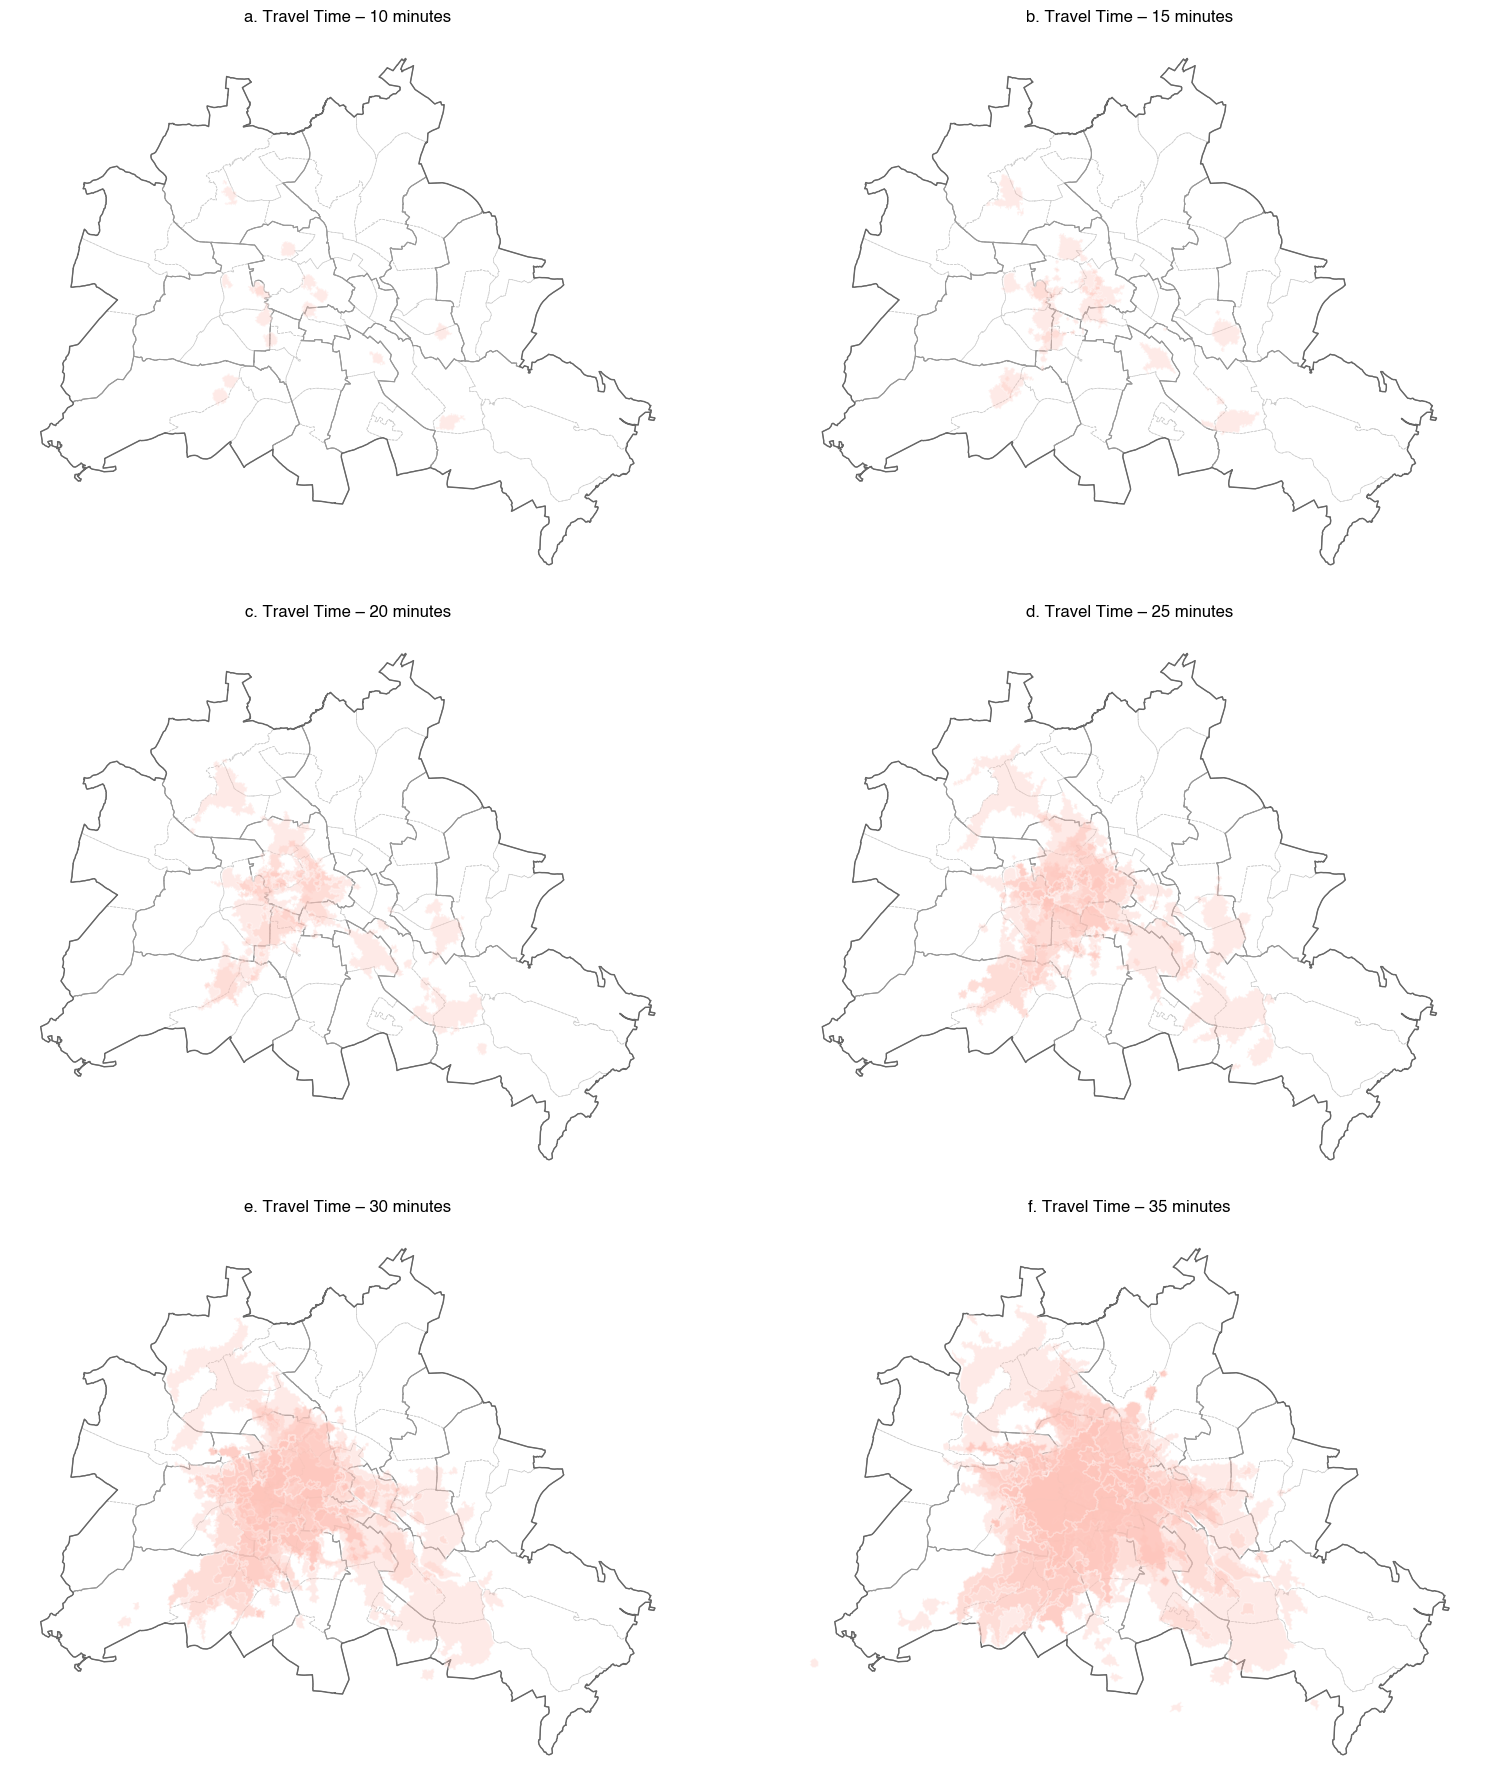

In [15]:
n_rows, n_cols = 3, 2   
fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(9 * n_cols, 6 * n_rows)
)

for idx, time_min in enumerate(isochrone_times):
    r, c = divmod(idx, n_cols)         
    ax = axs[r, c]

    file_path = os.path.join(base_path, f"iso_without_data_{time_min}_min.gpkg")
    market = gpd.read_file(file_path).to_crs("EPSG:25833")


    pgr.plot(ax=ax,facecolor='none',edgecolor='#cccccc',linewidth=0.5,linestyle='--')
    bz.plot(ax=ax,facecolor='none',edgecolor='#999999',linewidth=0.75)
    out.plot(ax=ax,facecolor='none',edgecolor='#666666',linewidth=1)

    market.plot(
        ax=ax,
        color="#FEC5BB",          #.reversed()   # <-- choose any matplotlib colormap
        alpha=0.35,
        edgecolor='white',
        linewidth=1,
        legend=True,
        legend_kwds={'shrink': 0.6, 'label': "demand‑capacity pressure"}
    )

    letter = string.ascii_lowercase[idx]  # 'a', 'b', 'c', …
    ax.set_title(f"{letter}. Travel Time – {time_min} minutes", fontsize=12, pad=8, fontweight='bold')
    ax.set_axis_off()
    plt.tight_layout()

save_path = os.path.join(hf, "Travel Time Test.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()

*Figure XX. Travel-Time API Test*

When constructing isochrones, it is important to correctly interpret the allocation of student housing capacity and higher education universities demand.

The allocation of student accommodations is performed using a spatial join between points and isochrone polygons. Since one student accommodations facility may be located within the catchment area of several universities, directly assigning its full capacity to each area would lead to a significant overestimation of supply. To avoid double-counting, each student accommodation facility first receives information about the number of isochrones in which it is located, after which its capacity is divided equally among all relevant areas. The adjusted values are then aggregated at the market area level. This approach allows for the correct distribution of available housing in accordance with the actual spatial structure of accessibility, taking into account the overlap of the areas of influence of different universities.

Similar to the distribution of dormitories, university demand (number of German students (`!s_de`), number of foreign students (`!s_aus`) and total number of students (`!s_all`)) is assigned to isochrones based on the principle of spatial intersection. Universities may also lie within several isochrones, especially when accessibility times are long (30–35 minutes). Therefore, the demand for each university is divided among all the zones within which it falls. This method eliminates artificial doubling of demand and creates a balanced distribution that reflects the real impact of universities on the housing market within their accessibility zones. The final demand values are aggregated at the market area level and can be compared with the distributed student accommodation capacity.

In [16]:
for time_min in isochrone_times:
    # Load isochrone data
    iso_file = f"{base_path}/iso_without_data_{time_min}_min.gpkg"
    iso_gdf = gpd.read_file(iso_file)
    
    # Reproject immediately
    if iso_gdf.crs != "EPSG:25833":
        iso_gdf = iso_gdf.to_crs("EPSG:25833")

    # Build multipolygons per tt_id 
    iso_multi = (
        iso_gdf.groupby(["tt_id", "origin_lon", "origin_lat"])
        .geometry.apply(lambda g: MultiPolygon([geom for geom in g]))
        .reset_index()
    )
    iso_multi_gdf = gpd.GeoDataFrame(iso_multi, geometry="geometry", crs="EPSG:25833")

    # Prepare central places (no geometry needed for merge)
    central_places_no_geom = central_places.drop(columns="geometry")
    central_places_no_geom["lon"] = central_places_no_geom["lon"].astype(float)

    # Merge on origin_lon/lon
    iso_multi_gdf["origin_lon"] = iso_multi_gdf["origin_lon"].astype(float)
    iso_dem = iso_multi_gdf.merge(
        central_places_no_geom,
        left_on="origin_lon",
        right_on="lon"
    )
    iso_dem = gpd.GeoDataFrame(iso_dem, geometry="geometry", crs="EPSG:25833")
    iso_dem = iso_dem.drop(columns=["origin_lon", "url"])
    iso_dem["geometry"] = iso_dem["geometry"].buffer(0)   # fix invalids

    # From here everything is already in EPSG:25833
    pbsa_cap_ready = pbsa_cap.copy()
    if "pbsa_id" not in pbsa_cap_ready.columns:
        pbsa_cap_ready["pbsa_id"] = pbsa_cap_ready.index
    
    iso_dem_ready = iso_dem.copy()
    if "iso_id" not in iso_dem_ready.columns:
        iso_dem_ready["iso_id"] = iso_dem_ready.index
    
    uni_dem = uni_dem.copy()
    if 'uni_id' not in uni_dem.columns:
        uni_dem['uni_id'] = uni_dem.index

    # PBSA allocation
    join_pbsa = gpd.sjoin(pbsa_cap_ready, iso_dem_ready, how="inner", predicate="intersects")
    n_iso_pbsa = join_pbsa.groupby("pbsa_id")["iso_id"].nunique().rename("n_iso_pbsa")
    join_pbsa = join_pbsa.merge(n_iso_pbsa, left_on="pbsa_id", right_index=True, how="left")
    cap_cols = ["!cap"]
    for c in cap_cols:
        join_pbsa[f"{c}_sum"] = join_pbsa[c] / join_pbsa["n_iso_pbsa"]
    iso_alloc_pbsa = (
        join_pbsa.groupby("iso_id")[[f"{c}_sum" for c in cap_cols]]
        .sum().reset_index()
    )
    
    # --- UNI allocation ---
    join_uni = gpd.sjoin(uni_dem, iso_dem_ready, how='inner', predicate='intersects')
    n_iso_uni = join_uni.groupby('uni_id')['iso_id'].nunique().rename('n_iso_uni')
    join_uni = join_uni.merge(n_iso_uni, left_on='uni_id', right_index=True, how='left')
    dem_cols = ['!s_aus_left', '!s_de_left', '!s_all_left']
    for c in dem_cols:
        join_uni[f'{c}_sum'] = join_uni[c] / join_uni['n_iso_uni']
    iso_alloc_uni = (join_uni.groupby('iso_id')[[f'{c}_sum' for c in dem_cols]]
                 .sum()
                 .reset_index())
    
    # Merge results
    market_area = iso_dem_ready.merge(iso_alloc_pbsa, on="iso_id", how="left")
    market_area = market_area.merge(iso_alloc_uni, on="iso_id", how="left")
    
    market_area = market_area.rename(columns={
        "!s_aus_left_sum": "!s_aus_sum",
        "!s_de_left_sum": "!s_de_sum",
        "!s_all_left_sum": "!s_all_sum",
    })
    
    # Ratios
    market_area["capacity_demand_ratio"] = (
        market_area["!cap_sum"] / market_area["!s_aus_sum"].replace(0, np.inf)
    )
    market_area["demand_capacity_pressure"] = (
        market_area["!s_aus_sum"] / market_area["!cap_sum"].replace(0, np.inf)
    )
    market_area["area"] = market_area.geometry.area / 1e6 # in sq km
    
    # PBSA count
    pbsa_pts = pbsa_cap_ready.copy()
    wb = gpd.sjoin(pbsa_pts, market_area[["iso_id", "geometry"]], how="inner", predicate="within")
    pbsa_counts = wb.groupby("iso_id").size()
    market_area["pbsa_count"] = market_area["iso_id"].map(pbsa_counts).fillna(0).astype(int)

    # Uni Count 
    uni_pts = uni_dem.copy()   # again, geometry is already active
    # Spatial join: UNI point within isochrone polygon
    wb = gpd.sjoin(uni_pts, market_area[['iso_id', 'geometry']], how='inner', predicate='within')
    # Count UNI per iso_id
    uni_counts = wb.groupby('iso_id').size()
    # Attach to market_area – fill missing with 0
    market_area['uni_count'] = market_area['iso_id'].map(uni_counts).fillna(0).astype(int)
    
    # Travel time
    market_area["travel_time_min"] = time_min
    
    #Cleaning 
    market_area['cluster'] = market_area['cluster'].map({
    'HH': 'High-High (HH)',
    'HL': 'High-Low (HL)', 
    'LH': 'Low-High (LH)',
    'LL': 'Low-Low (LL)',
    'NS': 'Not Significant (NS)'
    })
    columns_to_drop = ['origin_lat', 'origin_lon', 'cluster_aus', 'iso_id', 'lon']
    market_area = market_area.drop(columns=columns_to_drop, errors='ignore')

    # Save
    output_file = f"{base_path}/market_areas_{time_min}_min.gpkg"
    market_area.to_file(output_file, driver="GPKG")
    
    # Summary stats
    total_capacity_inside = market_area["!cap_sum"].sum()
    total_demand_inside = market_area["!s_aus_sum"].sum()

    uncovered_demand = total_demand_complete - total_demand_inside
    unused_capacity = total_capacity_complete - total_capacity_inside
    
    results_summary.append({
        "travel_time_min": time_min,
        "total_capacity_inside": total_capacity_inside,
        "total_demand_inside": total_demand_inside,
        "uncovered_demand": uncovered_demand,
        "unused_capacity": unused_capacity,
        # "market_areas_count": len(market_area),
        # "market_areas_with_capasity": len(market_area[market_area['!cap_sum'].notnull()]),
    })

By changing the time thresholds, it is possible to check the stability of market areas: whether the structure of supply and demand zones changes or remains stable. To do this, at the final stage, a summary of key indicators is formed for each tested time of availability, allowing us to assess how effectively the formed market areas reflect the real structure of supply and demand. The table (Table XX) contains: the total capacity of dormitories that fall within the isochrones (`total_capacity_inside`) and the total university demand covered by these same areas (`total_demand_inside`).

In [17]:
# Create summary DataFrame
summary_df = []

summary_df = pd.DataFrame(results_summary).round(1)

summary_df.sort_values("travel_time_min", inplace=True)

summary_df

,travel_time_min,total_capacity_inside,total_demand_inside,uncovered_demand,unused_capacity
0,10,3001.0,32358.5,16098.3,22816.0
1,15,6191.0,44461.9,3994.9,19626.0
2,20,9089.0,45344.2,3112.6,16728.0
3,25,15195.0,46592.4,1864.4,10622.0
4,30,17841.0,46976.1,1480.6,7976.0
5,35,20635.0,47224.8,1232.0,5182.0


*Table XX. Travel Time Summary Statistics*

In [18]:
output_path = r"../outputs/3.2_central_place_analysis/market_area_travel_time.xlsx" 
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    summary_df.to_excel(writer, sheet_name='base')

Comparing these indicators between different time thresholds (10–35 minutes) (Figure XX) allows us to determine the optimal radius of market influence of universities, as well as to identify structural imbalances between supply and demand associated with spatial constraints. This approach provides a quantitative basis for selecting the isochrone threshold and correctly forming market areas.

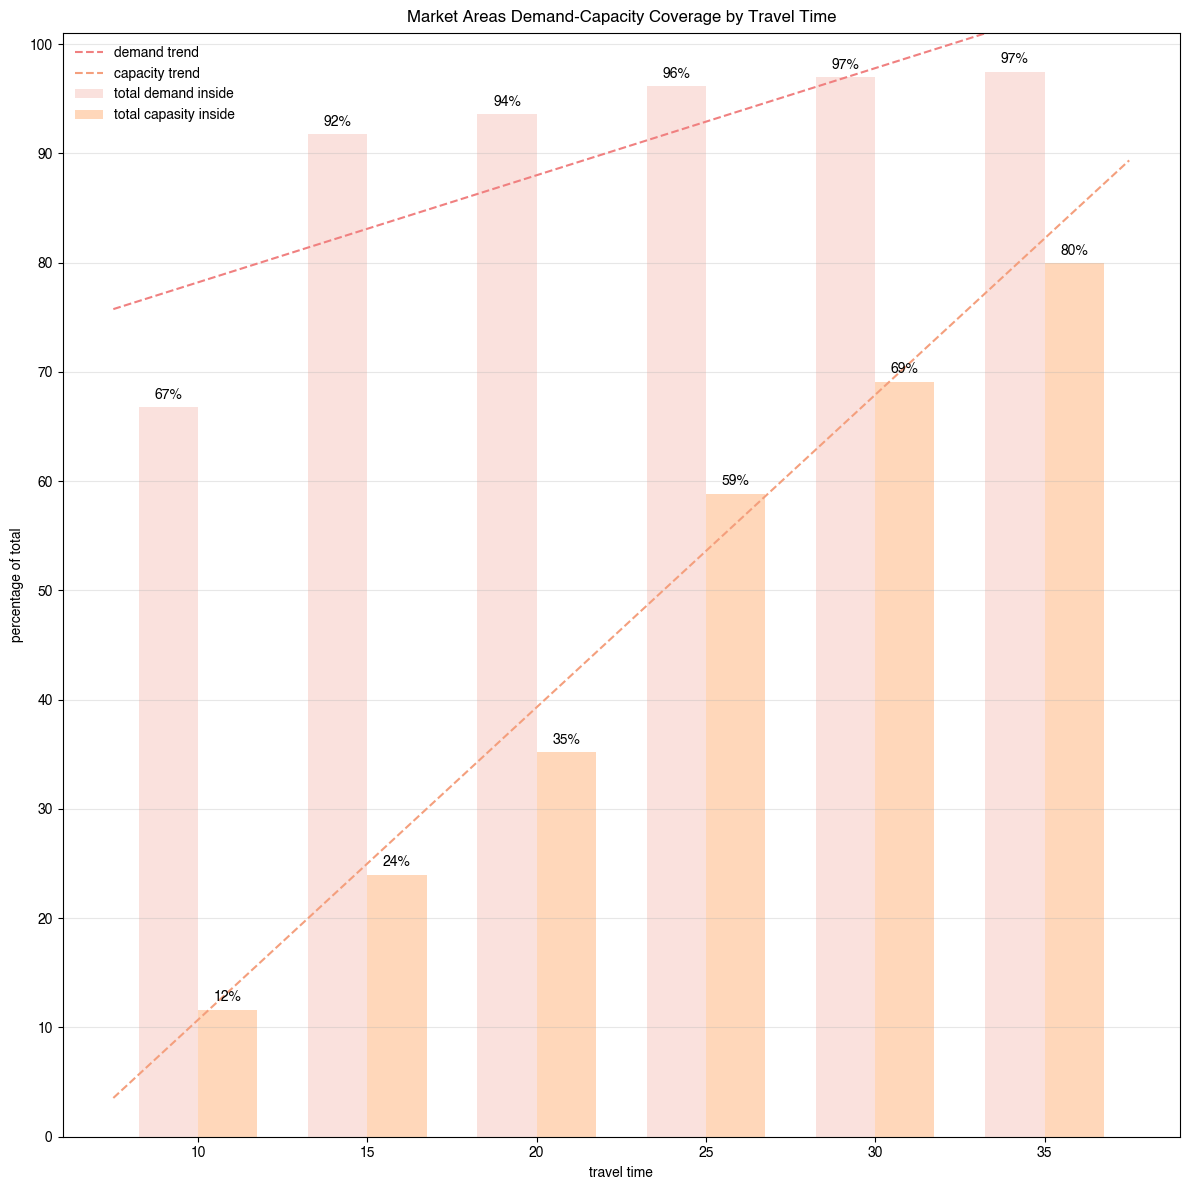

In [19]:
# Get the total values for percentage calculation
total_demand_complete = uni_dem['!s_aus'].sum()  # You'll need to load uni_dem data
total_capacity_complete = pbsa_cap['!cap'].sum()

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 12))

# Set up the bar positions
x = np.arange(len(summary_df))
width = 0.35

# Calculate percentages
demand_percentages = (summary_df['total_demand_inside'] / total_demand_complete) * 100
capacity_percentages = (summary_df['total_capacity_inside'] / total_capacity_complete) * 100


demand_coeffs    = np.polyfit(x, demand_percentages, 1)
capacity_coeffs  = np.polyfit(x, capacity_percentages, 1)

# Prepare a smooth x array for plotting the line
x_smooth = np.linspace(-0.5, len(summary_df)-0.5, 200)

# Evaluate the fitted lines
demand_trend    = np.polyval(demand_coeffs, x_smooth)
capacity_trend  = np.polyval(capacity_coeffs, x_smooth)

# Plot the trend lines
ax.plot(x_smooth, demand_trend,   color='#F08080',   lw=1.5, linestyle='--', label='demand trend')
ax.plot(x_smooth, capacity_trend, color='#F49F7D', lw=1.5, linestyle='--', label='capacity trend')

# Create bars
demand_bars = ax.bar(x - width/2, demand_percentages, width, label='total demand inside', 
                     color='#FAE1DD', alpha=1, linewidth=1)
capacity_bars = ax.bar(x + width/2, capacity_percentages, width, label='total capasity inside', 
                       color='#FFD7BA', alpha=1,  linewidth=1)



# Prepare a smooth x array for plotting the line
x_smooth = np.linspace(-0.5, len(summary_df)-0.5, 200)

# Customize the plot
ax.set_ylim(0, 101)                # a bit of head‑room for the trend lines
ax.set_yticks(np.arange(0, 101, 10))   # 0,10,20,...,100
ax.set_xlabel('travel time')
ax.set_ylabel('percentage of total')
ax.set_title('Market Areas Demand-Capacity Coverage by Travel Time', fontsize=12, pad=8, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(summary_df['travel_time_min'])
plt.legend(loc='best', frameon=False)
ax.grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
def add_labels(bars, percentages):
    for bar, percentage in zip(bars, percentages):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{percentage:.0f}%', ha='center', va='bottom', fontsize=10)

add_labels(demand_bars, demand_percentages)
add_labels(capacity_bars, capacity_percentages)

plt.tight_layout()

save_path = os.path.join(hf, "Market Areas Demand-Capacity Coverage by Travel Time.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()

*Figure XX. Market Areas Demand-Capacity Coverage by Travel Time*

The results of the travel time test demonstrate that increasing the time threshold for accessibility significantly affects the degree of coverage of university demand and the capacity of student housing included in market areas. However, the effect grows unevenly, and it is precisely this dynamic that allows us to determine the optimal travel time value.

First, at thresholds of 10–25 minutes, there is a significant discrepancy between the share of demand covered and the share of capacity included. For example, at 25 minutes, the market already covers 96% of total demand, but only 59% of housing capacity. This imbalance indicates that with short isochrones, a significant portion of dormitories remain formally ‘outside the market,’ which leads to artificially inflated estimates of the deficit and local market pressure.

Secondly, starting at 30 minutes, the volume of included capacity increases sharply, reaching 69%, and by 35 minutes, 80%, which reflects a significant improvement in the spatial correspondence between university demand and student accommodation capacity. At the same time, there is no further noticeable growth in demand coverage: even at 20 minutes, more than 94% of student demand is covered, and at 30–35 minutes, 97%. This means that an increase in travel time in this range mainly affects the housing supply rather than changing the demand pattern.

Thus, the 35-minute threshold represents an optimal compromise. 

Moreover, according to a study by Menz & Mandl (2024), students studying mostly in person spend 5 hours more per week on study-related activities compared to students studying mostly online. Thus, it can be concluded that full-time students spend an additional 5 hours per week commuting, which is equivalent to approximately 1 hour per day or 30 minutes each way. 

# Market Areas Analysis 

Spatial economics and central place metrics were used to analyse market areas (Table XX). 

In [20]:
market_area[[
    "code",
    "name",
    "own",
    "cluster",
    "!cap_sum",
    "!s_aus_sum",
    "!s_de_sum",
    "!s_all_sum"
]].round(1)

#market_area.describe().round(1)

,code,name,own,cluster,!cap_sum,!s_aus_sum,!s_de_sum,!s_all_sum
0,HS0180,Charite - Universitätsmedizin Berlin,Public University,Low-High (LH),1455.4,3072.6,8126.0,11198.7
1,HS0180,Charite - Universitätsmedizin Berlin,Public University,High-Low (HL),511.5,2563.9,10281.7,12845.5
2,HS5802,U of Europe for Appl.Sc.Potsdam i.Berlin,Privat University,Low-High (LH),1594.8,3520.2,9143.1,12663.4
3,HS7690,Hochschule für Technik und Wirtschaft Berlin,Public University,Low-High (LH),3808.8,4446.4,19321.6,23768.1
4,HS7710,Berliner Hochschule für Technik,Public University,Low-High (LH),1409.9,3023.1,7929.0,10952.1
5,HS7721,"HWR Berlin, FB Wirtschaft",Public University,High-High (HH),884.2,5449.5,16643.3,22092.8
6,HS7971,SRH Berlin U of Appl. Sciences in Berlin,Privat University,Low-High (LH),1687.0,1244.6,1773.3,3017.9
7,HS0200,Humboldt-Universität Berlin,Public University,Low-High (LH),1245.5,4352.1,18945.9,23297.9
8,HS0200,Humboldt-Universität Berlin,Public University,Low-High (LH),2000.0,3190.8,9539.3,12730.1
9,HS1380,Freie Universität Berlin,Public University,Low-High (LH),885.8,2739.1,10922.5,13661.6


*Table XX. Market Areas*

## Spatial Economics Metrics

Spatial Economics indicators are important for further calculation of capacity–demand balance and central place metrics.

**Capacity–Demand Ratio**   
This indicator reflects the ratio between the supply of student housing and university demand within each market area. It is calculated as the share of the total capacity of all student accommodation  in the market area relative to the total demand from international students (`market_area[‘capacity_demand_ratio’] = !cap_sum / !s_aus_sum`).
High ratio values indicate areas with a relative oversupply, while low values indicate a shortage of housing relative to demand. This indicator helps to identify areas where the market is potentially balanced or, conversely, under the pressure.

**Demand–Capacity Pressure**    
This indicator is the inverse ratio and is calculated as the share of total university demand relative to student housing capacity (`market_area[‘demand_capacity_pressure’] = !s_aus_sum / !cap_sum`). It is interpreted as the degree of market pressure: the higher the value, the greater the load on the available supply and the more acute the shortage. 

**Number of Student Accommodations**    
This indicator determines how many student accommodation facilities are located within a specific market area (`pbsa_counts = wb.groupby(‘iso_id’).size()`). 

**Number of Higher Education Universities**     
This indicator reflects how many higher education institutions fall within the boundaries of the market area (`uni_counts = wb.groupby(“iso_id”).size()`). 

**Market Area Size**    
The area of each market area is calculated as the area of its geometry in square kilometres (`market_area[‘area’] = market_area.geometry.area / 1e6`).

The main result of the analysis of spatial economic metrics is the capacity–demand balance (Figure XX), which allows for a direct comparison of the aggregate demand of international students within each market area with the available supply of places in student accommodation.

As can be seen in the graph, in the vast majority of university market areas, university international demand significantly exceeds available student accommodation capacity. Almost all points are below the ideal equilibrium line (45°), indicating a structural supply shortage and systemic pressure on the student housing market. The size of the points reflects the degree of pressure on a particular university. The smallest pressure is on the market area formed by SRH Berlin University of Applied Sciences, where capacity exceeds demand. The greatest pressure is on the market area formed by the University of Business and Law, where demand exceeds capacity by 6.2 times. 

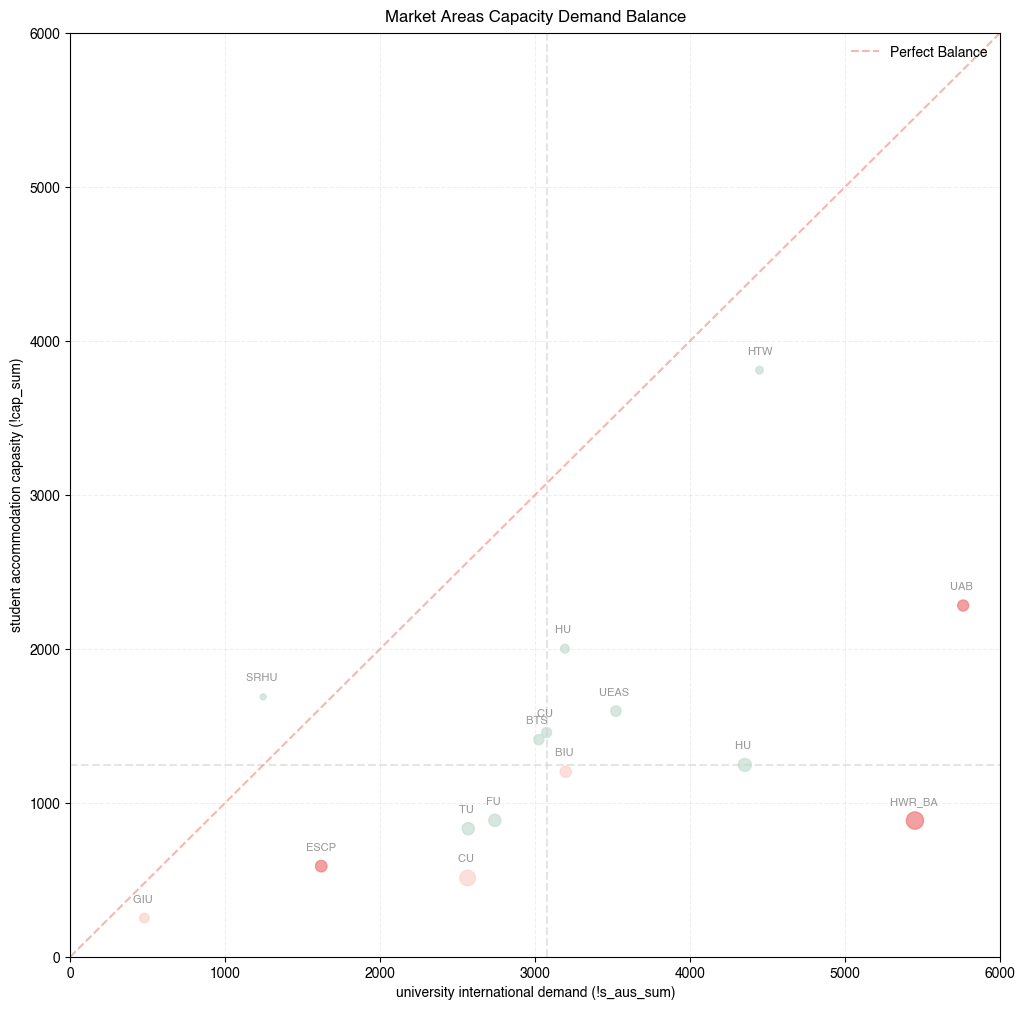

In [21]:
demand_median = market_area['!s_aus_sum'].median()
capacity_median = market_area['!cap_sum'].median()

mpl.rcParams['font.family'] = 'Helvetica'

# Plot
f, ax = plt.subplots(1, figsize=(12, 12))
x_min, x_max = 0, 6000  # For capacity_demand_ratio.clip(0, 5)
y_min, y_max = 0, 6000  

ax.scatter(market_area['!s_aus_sum'], market_area['!cap_sum'], color = market_area['color'], s=(market_area['demand_capacity_pressure'])*25, alpha=0.75)

for idx, row in market_area.iterrows():
    offset = 10
    ax.annotate(row['abr'], #abr
        xy=(row['!s_aus_sum'], row['!cap_sum']),  # Original point position
        xytext=(0, offset),  # Move text 5 points upward from the point
        textcoords='offset points',  # Use offset coordinates for xytext
        color='#999999', 
        fontsize=8, 
        alpha=1,
        ha='center',    # Horizontal alignment: center
        va='bottom' if idx % 2 == 0 else 'bottom'     # Vertical alignment: bottom of text above point
    )

ax.axhline(capacity_median, color='#cccccc', linestyle='--', alpha=0.5)
ax.axvline(demand_median, color='#cccccc', linestyle='--', alpha=0.5)
ax.set_xlabel('university international demand (!s_aus_sum)')
ax.set_ylabel('student accommodation capasity (!cap_sum)')
ax.set_title('Market Areas Capacity Demand Balance', fontsize=12, pad=8, fontweight='bold')
ax.axline((0, 0), slope=1, color='#F4978E', linestyle='--', alpha=0.7, label='Perfect Balance')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.grid(True, color='#cccccc', linestyle='--', alpha=0.3)
plt.legend(loc='upper right', frameon=False)

save_path = os.path.join(hf, "Market Areas Capacity Demand Balance.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()

*Figure XX. Market Areas Capacity Demand Balance*

## Central Place Metrics

**Centrality**  
The first challenge was to find some way of measuring the centrality of an urban place (King, 1986). To calculate centrality Godlund (1956) used the following formula:  

$$
C \;=\; \sqrt{\,(B)\,(m) \;-\; (P)\,(k)\,}
$$


where:

B — a count of the number of shops in the place 
m — a weighting factor that took into account the comparative average size of the shops  
P — the population of the town  
k — was an index of the average accessibility to retail trade services enjoyed by any one inhabitant of the larger region in which the central place was located    

In a study of the student housing market, centrality can be determined using a modified version of Godlund's formula.

$$
C \;=\; \sqrt{\,(Csa +Cuni)\,(m) \;-\; (D)\,(Ci/Di)\,}
$$ 

where:

Csa +Cuni — a sum of the number of student accommodations and higher education  universities in the market area     
m — is a constant calculated during manual tests (`m=50`)     
D — the total international demand      
Ci/Di — a capacity-demand ratio      

In [22]:
market_area["!s_aus_sum"] = market_area["!s_aus_sum"].round(3)

In [23]:
m = 50

market_area["centrality"] = np.sqrt(((market_area["pbsa_count"] + market_area["uni_count"]) * m) - 
                                    (market_area["!s_aus_sum"] * market_area["capacity_demand_ratio"])).fillna(0.0).round(3)

market_area[["fname", "pbsa_count", "uni_count", "capacity_demand_ratio",
           "!s_aus_sum", "centrality"]].head(15).sort_values("centrality", ascending=False) 

,fname,pbsa_count,uni_count,capacity_demand_ratio,!s_aus_sum,centrality
2,University of Europe for Applied Sciences,42,44,0.453028,3520.246,52.012
13,University of the Arts Berlin,50,48,0.395898,5760.527,51.180
5,"Hochschule für Wirtschaft und Recht (Berlin, F...",32,37,0.162263,5449.490,50.653
0,Charité - Universitätsmedizin Berlin,37,38,0.473682,3072.597,47.902
8,Humboldt University of Berlin,44,41,0.626782,3190.825,47.435
12,Berlin International University of Applied Sci...,33,35,0.375696,3196.726,46.894
4,Berlin School of Technology (Technical Univers...,36,34,0.466377,3023.068,45.718
10,Technical University of Berlin,25,18,0.323625,2567.892,36.318
11,ESCP Business School Berlin,17,13,0.363232,1619.219,30.197
9,Free University of Berlin,19,16,0.323402,2739.128,29.397


*Table XX. Centrality Central Place Metrics*

The market areas formed by the Humboldt University of Berlin and the University of Applied Sciences for Technology and Economics Berlin have zero centrality, which can be explained by their spatial location in Treptow-Köpenick and Lichtenberg, respectively. 

**Service Range Adequacy**  
It is based on the key principle of central place theory: service range determines the size of the market territory necessary for the sustainable operation of the facility. As King (1986) notes, the higher the ‘service range’ of a product or service, the larger the area that must provide a sufficient flow of users, and the higher the probability that such a facility will be located in a larger urban centre. Service Range Adequacy allows us to assess how well each territory meets the expected level of service and contributes to the sustainable functioning of the student housing market. It is calculated as the relative share of demand attributable to each market area (`market_area[“cntr_service_range_adequacy”] = market_area[“!s_aus_sum”] / total_demand_complete)`)

In [24]:
total_demand_complete = uni_dem['!s_aus'].sum()
market_area['cntr_service_range'] = (
    market_area['!s_aus_sum'] / total_demand_complete).round(3)

market_area[["fname","!s_aus_sum", "centrality", "cntr_service_range"]].head(15).sort_values("cntr_service_range", ascending=False) 

,fname,!s_aus_sum,centrality,cntr_service_range
13,University of the Arts Berlin,5760.527,51.180,0.119
5,"Hochschule für Wirtschaft und Recht (Berlin, F...",5449.490,50.653,0.112
3,University of Applied Sciences for Technology ...,4446.418,0.000,0.092
7,Humboldt University of Berlin,4352.098,0.000,0.090
2,University of Europe for Applied Sciences,3520.246,52.012,0.073
8,Humboldt University of Berlin,3190.825,47.435,0.066
12,Berlin International University of Applied Sci...,3196.726,46.894,0.066
0,Charité - Universitätsmedizin Berlin,3072.597,47.902,0.063
4,Berlin School of Technology (Technical Univers...,3023.068,45.718,0.062
9,Free University of Berlin,2739.128,29.397,0.057


*Table XX. Service Range Adequacy Central Place Metrics*

**Hierarchy Rank**  
According to King's approach, the hierarchy of urban places is defined not only by their size, but primarily by the number and order of the functions they perform (King, 1986, p. 22).

Following this logic, the ranking of market areas in this study is based on their functional capacity, expressed through two key indicators: centrality and service range adequacy. These values are combined into a composite index (`market_area[“cntr_hierarchy”] = ((market_area[“centrality”]/100) + (market_ara[“cntr_service_range”])).round(3)`). The hierarchical ranking allows us to see not only the current configuration of supply and demand, but also the structural role of each market area in the urban system, identifying higher-order centres and lower-level areas.

In [25]:
market_area['cntr_hierarchy'] = (
    (market_area['centrality']/100) + (market_area['cntr_service_range'])).round(3)

market_area['cntr_hierarchy_rank'] = pd.qcut(
    market_area['cntr_hierarchy'],
    q=5, labels=range(1, 6)   # 1‑5 classes
)

market_area[["fname","!s_aus_sum", "centrality", "cntr_service_range", 
             'cntr_hierarchy', 'cntr_hierarchy_rank']].head(15).sort_values("cntr_hierarchy", ascending=False) 

,fname,!s_aus_sum,centrality,cntr_service_range,cntr_hierarchy,cntr_hierarchy_rank
13,University of the Arts Berlin,5760.527,51.180,0.119,0.631,5
5,"Hochschule für Wirtschaft und Recht (Berlin, F...",5449.490,50.653,0.112,0.619,5
2,University of Europe for Applied Sciences,3520.246,52.012,0.073,0.593,5
0,Charité - Universitätsmedizin Berlin,3072.597,47.902,0.063,0.542,4
8,Humboldt University of Berlin,3190.825,47.435,0.066,0.540,4
12,Berlin International University of Applied Sci...,3196.726,46.894,0.066,0.535,4
4,Berlin School of Technology (Technical Univers...,3023.068,45.718,0.062,0.519,3
10,Technical University of Berlin,2567.892,36.318,0.053,0.416,3
9,Free University of Berlin,2739.128,29.397,0.057,0.351,3
11,ESCP Business School Berlin,1619.219,30.197,0.033,0.335,2


*Table XX. Hierarchy Rank Central Place Metrics*

Market Areas Hierarchy Rank demonstrates the distribution of central places by hierarchical classes in accordance with Central Place Theory.

**Hierarchy Rank - 5. Primary Central Places**   

Primary Central Places (Figure XX) are formed around the University of the Arts Berlin (UAB), the University of Europe for Applied Sciences (UEAS) and the School of Economics and Law (HWR_BA). Although according to King (1986), centrality is not determined by the physical size of the territory, these market areas have some of the largest areas, more than 90 km² each. This is because top-level zones must have a sufficiently wide coverage to serve a large number of functions and significant volumes of demand.

Geographically, these market areas are located mainly in the districts of Mitte, Charlottenburg-Wilmersdorf and Friedrichshain-Kreuzberg, as well as partly in Tempelhof-Schöneberg, Steglitz-Zehlendorf and Neukölln, forming a distinct axis in a south-westerly direction. Together, they account for about 32% of total international student demand, which highlights their systemic role in the city's university infrastructure.

It is worth noting that two of the three primary centres belong to the High–High cluster, meaning they are stable magnets for international students, around which areas of high demand and growing market pressure are forming. However, the greatest pressure is observed in the School of Economics and Law market zone, where demand exceeds available capacity by 6.2 times, making this zone the most vulnerable in the hierarchy of central locations. This imbalance highlights the critical shortage of infrastructure and the need to prioritise the expansion of the housing stock near this educational cluster.

Together, the primary central places form the core of Berlin's student urbanisation, where key educational functions, large volumes of demand and the most significant infrastructure imbalances are concentrated. Their high hierarchical position confirms the central role of these areas in the urban structure, but at the same time demonstrates the vulnerability of the system: even higher-order centres face a significant housing shortage and growing market pressure.

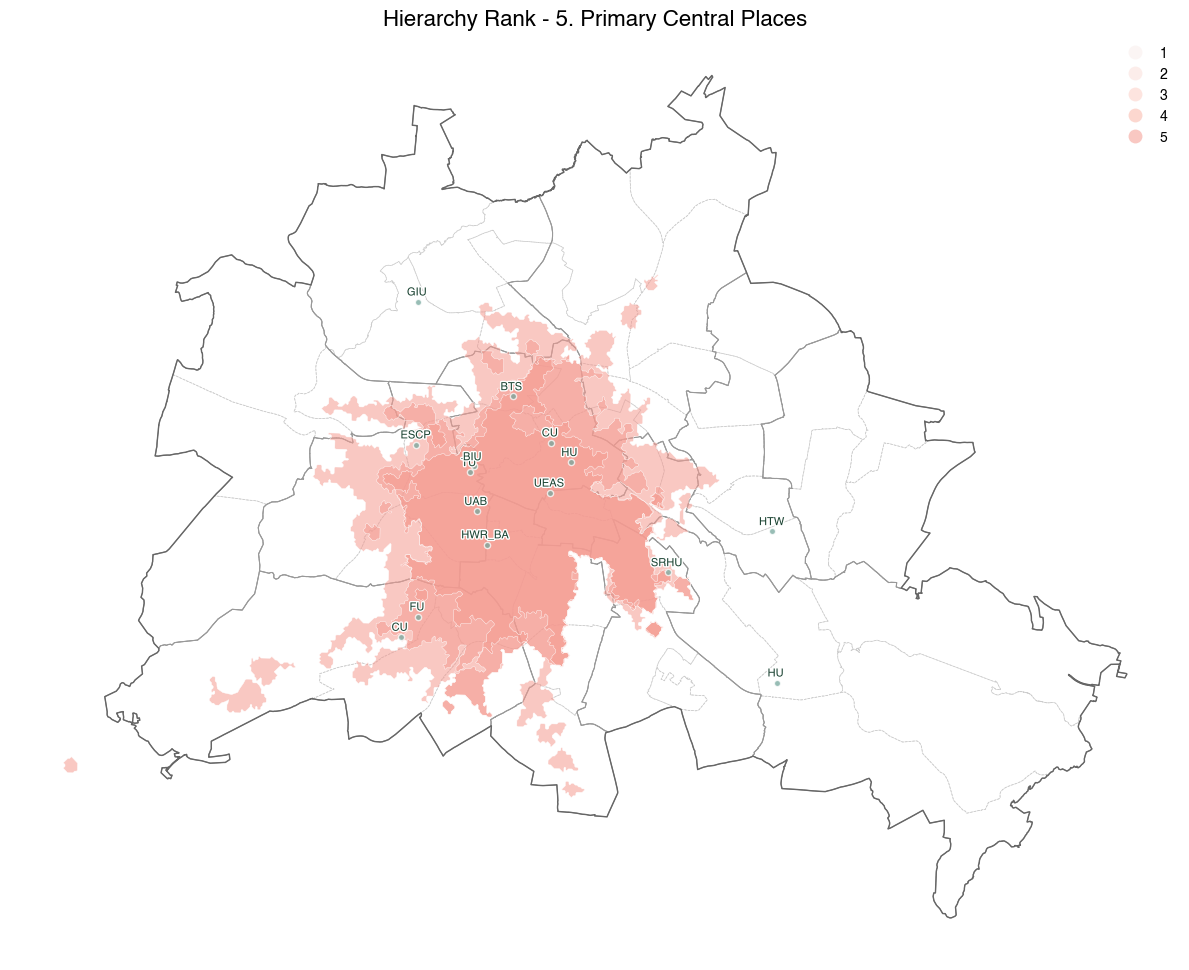

In [27]:
fig, axs  = plt.subplots(figsize=(12, 12))

pgr.plot(ax=axs, facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=axs, facecolor='none', edgecolor='#999999', linewidth=0.75)
out.plot(ax=axs, facecolor='none', edgecolor='#666666', linewidth=1)

market_area[market_area['cntr_hierarchy_rank'] == 5].plot(ax=axs,
          column='cntr_hierarchy_rank',
          cmap=cmap_pi,
          alpha=0.55,
          edgecolor='none',
          linewidth=0.3,
          legend=True,
          legend_kwds={'frameon': False},
          label = 'hierarchy rank', 
          vmin=0,
          vmax=5)

market_area[market_area['cntr_hierarchy_rank'] == 5].plot(
    ax=axs,
    edgecolor='white',  # variable for colormap
    facecolor="none",        # transparent polygons  # edge colors from your column
    linewidth=0.3,
    alpha=1
)

central_places.plot(ax=axs,
           color='#76A79D', 
           markersize=20,
           #markersize= 10,
           alpha=0.75,
           edgecolor='white',
           linewidth=1)
for _, row in central_places.iterrows():
    offset = 3  # vertical offset in points
    axs.annotate(
        row['abr'],                           # abbreviation
        xy=(row.geometry.x, row.geometry.y),  # coords from the Point
        xytext=(0, offset),                   # lift the text a bit
        textcoords='offset points',
        color='#1b4332',
        fontsize=8,
        ha='center',
        va='bottom',
        alpha=1,
        zorder=6,
        path_effects=[
            path_effects.Stroke(linewidth=2, foreground='white'),
            path_effects.Normal()
        ]
    )

axs.set_title('Hierarchy Rank - 5. Primary Central Places', fontsize=16, fontweight='bold')
axs.set_axis_off()
plt.tight_layout()

save_path = os.path.join(hf, "Hierarchy Rank - 5. Primary Central Places.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()

*Figure XX. Primary Central Places*

In [26]:
market_area[market_area['cntr_hierarchy_rank'] == 5][["fname","!s_aus_sum", "centrality", "cntr_service_range", 'cntr_hierarchy', 'cntr_hierarchy_rank']].head(15).sort_values("cntr_hierarchy", ascending=False) 

,fname,!s_aus_sum,centrality,cntr_service_range,cntr_hierarchy,cntr_hierarchy_rank
13,University of the Arts Berlin,5760.527,51.180,0.119,0.631,5
5,"Hochschule für Wirtschaft und Recht (Berlin, F...",5449.490,50.653,0.112,0.619,5
2,University of Europe for Applied Sciences,3520.246,52.012,0.073,0.593,5


*Table XX. Primary Central Places*

**Hierarchy Rank - 4. Secondary Central Places**   

Secondary Central Places Centres (Figure XX) are formed by Humboldt University of (HU), International University of Applied Sciences (BIU) and Charité University Hospital (CU). These market areas are secondary central places, i.e., high-order centres that have significant functional saturation but are lower than primary centres in terms of scale of attraction and infrastructure concentration.

Geographically, secondary central places are located east of primary central places, covering parts of the Lichtenberg and Pankow districts and forming a distinct west-east axis in the spatial structure of the student housing market. This configuration reflects the expansion of the city's education system in an easterly direction, which is historically less saturated with higher education institutions. Together, these areas account for about 20% of the total demand from international students, confirming their significant but not dominant role in the urban hierarchy.

The average demand–capacity pressure value of 2.1 confirms that demand exceeds current supply by more than double. This creates moderate but stable market pressure, indicating the need for strategic expansion of student infrastructure and further development of public-private initiatives in the field of student accommodation.

Thus, secondary central places function as sub-regional centres in the urban hierarchy, playing a key role in rebalancing demand, ensuring access to higher education and shaping future growth trends in Berlin's student housing market.

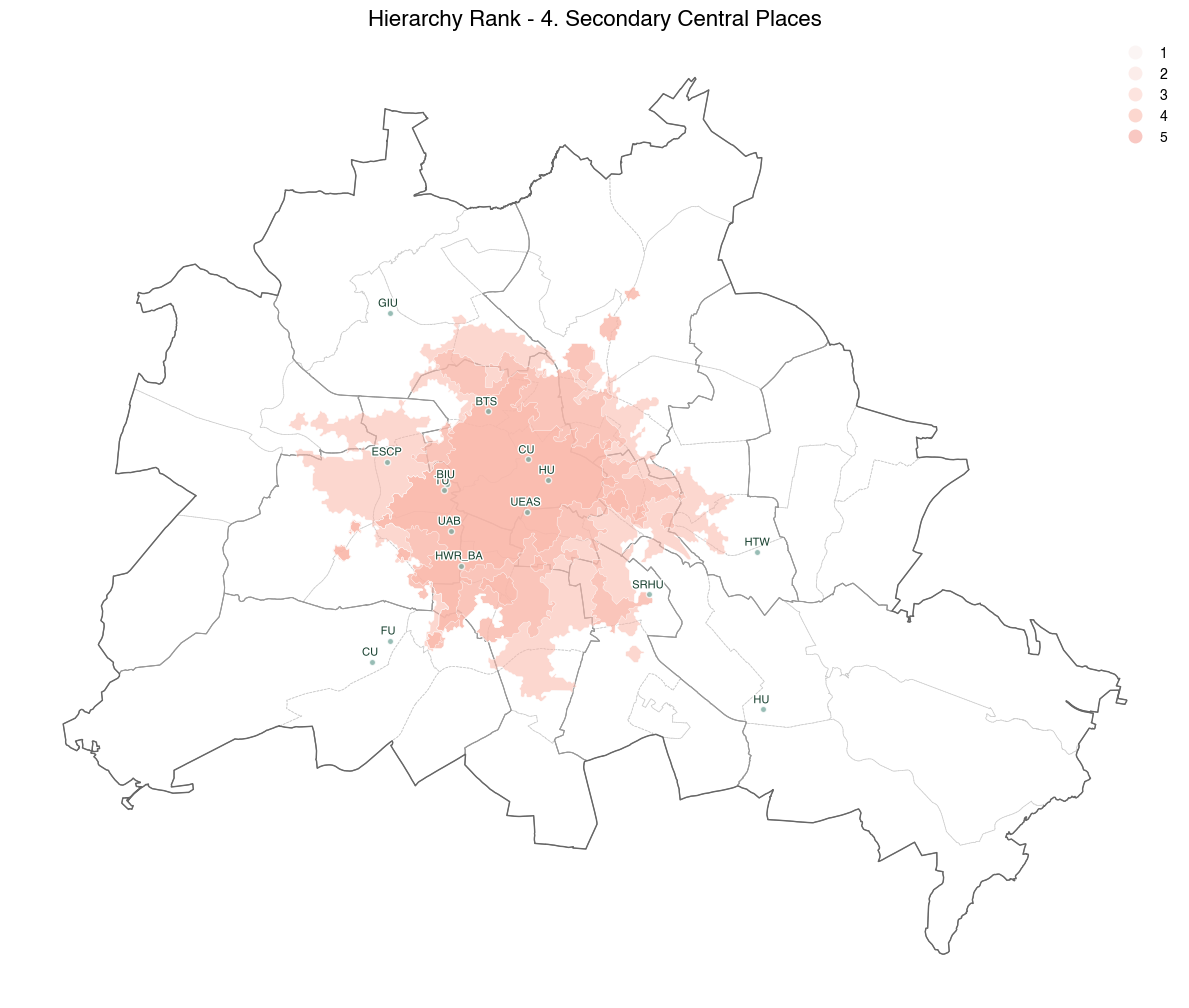

In [28]:
fig, axs  = plt.subplots(figsize=(12, 12))

pgr.plot(ax=axs, facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=axs, facecolor='none', edgecolor='#999999', linewidth=0.75)
out.plot(ax=axs, facecolor='none', edgecolor='#666666', linewidth=1)

market_area[market_area['cntr_hierarchy_rank'] == 4].plot(ax=axs,
          column='cntr_hierarchy_rank',
          cmap=cmap_pi,
          alpha=0.55,
          edgecolor='none',
          linewidth=0.3,
          legend=True,
          legend_kwds={'frameon': False},
          label = 'hierarchy rank', 
          vmin=0,
          vmax=5)

market_area[market_area['cntr_hierarchy_rank'] == 4].plot(
    ax=axs,
    edgecolor='white',  # variable for colormap
    facecolor="none",        # transparent polygons  # edge colors from your column
    linewidth=0.3,
    alpha=1
)

central_places.plot(ax=axs,
           color='#76A79D', 
           markersize=20,
           #markersize= 10,
           alpha=0.75,
           edgecolor='white',
           linewidth=1)
for _, row in central_places.iterrows():
    offset = 3  # vertical offset in points
    axs.annotate(
        row['abr'],                           # abbreviation
        xy=(row.geometry.x, row.geometry.y),  # coords from the Point
        xytext=(0, offset),                   # lift the text a bit
        textcoords='offset points',
        color='#1b4332',
        fontsize=8,
        ha='center',
        va='bottom',
        alpha=1,
        zorder=6,
        path_effects=[
            path_effects.Stroke(linewidth=2, foreground='white'),
            path_effects.Normal()
        ]
    )

axs.set_title('Hierarchy Rank - 4. Secondary Central Places', fontsize=16, fontweight='bold')
axs.set_axis_off()
plt.tight_layout()

save_path = os.path.join(hf, "Hierarchy Rank - 4. Secondary Central Places.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()

*Figure XX. Secondary Central Places*

In [33]:
market_area[market_area['cntr_hierarchy_rank'] == 4][["fname","!s_aus_sum", "centrality", "cntr_service_range", 'cntr_hierarchy', 'cntr_hierarchy_rank']].head(15).sort_values("cntr_hierarchy", ascending=False) 

,fname,!s_aus_sum,centrality,cntr_service_range,cntr_hierarchy,cntr_hierarchy_rank
0,Charité - Universitätsmedizin Berlin,3072.597,47.902,0.063,0.542,4
8,Humboldt University of Berlin,3190.825,47.435,0.066,0.540,4
12,Berlin International University of Applied Sci...,3196.726,46.894,0.066,0.535,4


*Table XX. Secondary Central Places*

**Hierarchy Rank - 3. Tertiary Central Places**

Tertiary Central Places (Figure XX) are formed around the Technical University of Berlin (TUB), Free University (FU) and Berlin School of Technology (BTS). These universities represent significant but less dominant centres of demand, located on the periphery of the primary and secondary central places.

Geographically, tertiary central places occupy areas to the north and south of secondary central places, covering a significant part of Steglitz-Zehlendorf and Reinickendorf. In this way, they support the established south-western educational axis extending from the primary central places and, at the same time, form a new north-south axis in the spatial structure of the student housing market. This configuration reflects the complex multipolar organisation of demand characteristic of a large polycentric city.

Together, these market areas account for about 17% of total international student demand, making them significant but not dominant elements in the structure of central places. 

It is noteworthy that all three universities forming tertiary central places belong to the Low–High (LH) cluster and are public. This combination indicates the high educational potential of these areas and their ability to be included in existing clusters, but at the same time demonstrates the lack of full strategic integration into established centres of student urbanisation.

The average demand–capacity pressure value is 2.8, which is higher than that of secondary central places. This indicates that demand is almost three times higher than the available supply. Consequently, tertiary central places are critically important areas of hidden deficit, where a growing gap is forming between the educational potential of universities and the lack of adequate housing infrastructure. 

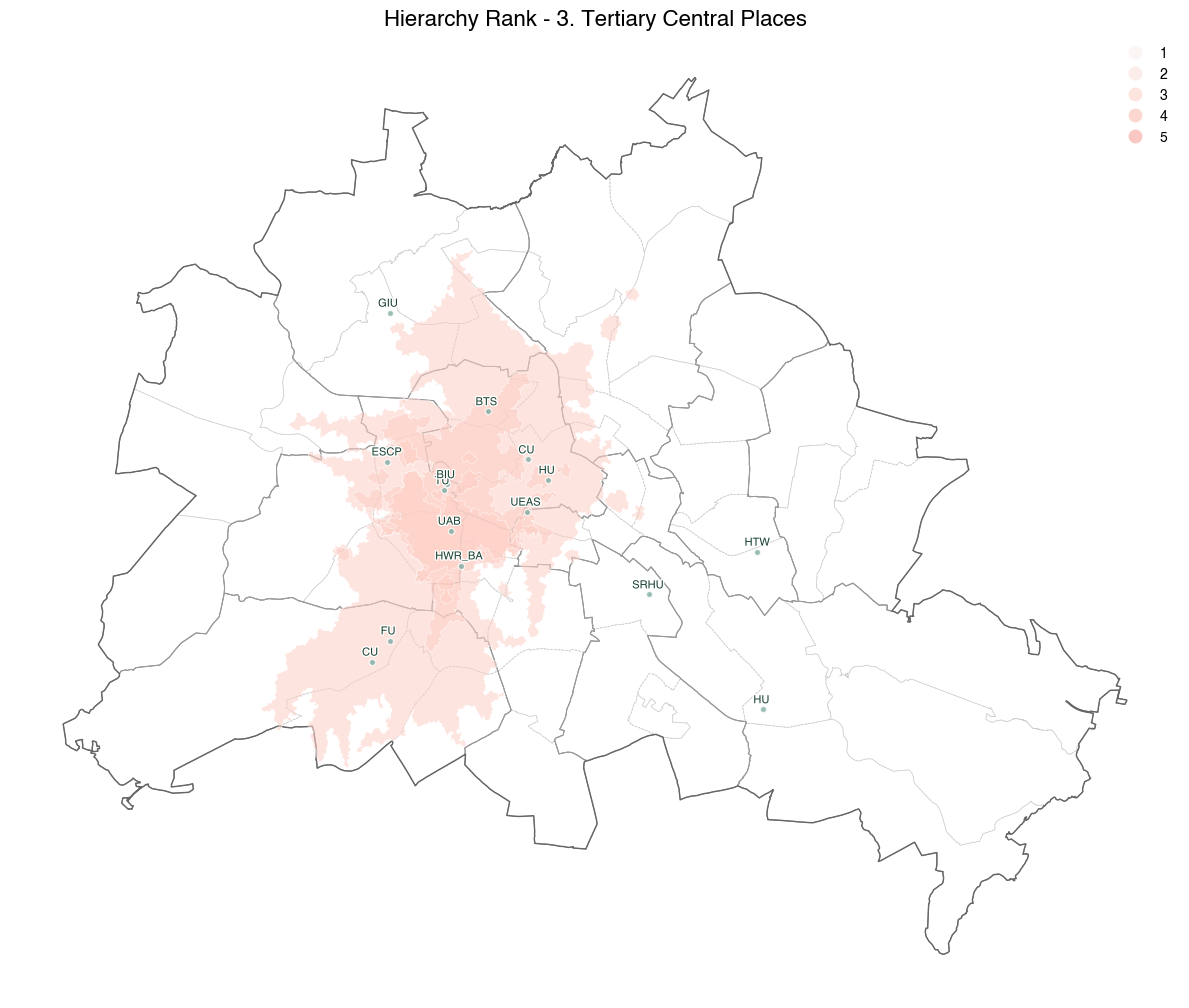

In [29]:
fig, axs  = plt.subplots(figsize=(12, 12))

pgr.plot(ax=axs, facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=axs, facecolor='none', edgecolor='#999999', linewidth=0.75)
out.plot(ax=axs, facecolor='none', edgecolor='#666666', linewidth=1)

market_area[market_area['cntr_hierarchy_rank'] == 3].plot(ax=axs,
          column='cntr_hierarchy_rank',
          cmap=cmap_pi,
          alpha=0.55,
          edgecolor='none',
          linewidth=0.3,
          legend=True,
          legend_kwds={'frameon': False},
          label = 'hierarchy rank', 
          vmin=0,
          vmax=5)

market_area[market_area['cntr_hierarchy_rank'] == 3].plot(
    ax=axs,
    edgecolor='white',  # variable for colormap
    facecolor="none",        # transparent polygons  # edge colors from your column
    linewidth=0.3,
    alpha=1
)

central_places.plot(ax=axs,
           color='#76A79D', 
           markersize=20,
           #markersize= 10,
           alpha=0.75,
           edgecolor='white',
           linewidth=1)
for _, row in central_places.iterrows():
    offset = 3  # vertical offset in points
    axs.annotate(
        row['abr'],                           # abbreviation
        xy=(row.geometry.x, row.geometry.y),  # coords from the Point
        xytext=(0, offset),                   # lift the text a bit
        textcoords='offset points',
        color='#1b4332',
        fontsize=8,
        ha='center',
        va='bottom',
        alpha=1,
        zorder=6,
        path_effects=[
            path_effects.Stroke(linewidth=2, foreground='white'),
            path_effects.Normal()
        ]
    )

axs.set_title('Hierarchy Rank - 3. Tertiary Central Places', fontsize=16, fontweight='bold')
axs.set_axis_off()
plt.tight_layout()

save_path = os.path.join(hf, "Hierarchy Rank - 3. Tertiary Central Places.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()

*Figure XX. Tertiary Central Places*

In [34]:
market_area[market_area['cntr_hierarchy_rank'] == 3][["fname","!s_aus_sum", "centrality", "cntr_service_range", 'cntr_hierarchy', 'cntr_hierarchy_rank']].head(15).sort_values("cntr_hierarchy", ascending=False) 

,fname,!s_aus_sum,centrality,cntr_service_range,cntr_hierarchy,cntr_hierarchy_rank
4,Berlin School of Technology (Technical Univers...,3023.068,45.718,0.062,0.519,3
10,Technical University of Berlin,2567.892,36.318,0.053,0.416,3
9,Free University of Berlin,2739.128,29.397,0.057,0.351,3


*Table XX. Tertiary Central Places*

**Hierarchy Rank - 2. Local Central Places** 

Local Central Places (Figure XX) are formed around SRH Berlin University of Applied Sciences (SRHU), Charité University Hospital (CU) and ESCP Business School Berlin (ESCP). These universities act as local centres, primarily serving the surrounding areas and acting as a link between larger secondary and tertiary central places.

Geographically, these market areas are mainly located in the districts of Friedrichshain-Kreuzberg and Neukölln, as well as partly in Mitte, Charlottenburg-Wilmersdorf, Tempelhof-Schöneberg, Treptow-Köpenick and Lichtenberg. Spatially, they occupy positions south of secondary central places and simultaneously support two key axes of the urban structure: the west-east axis formed by secondary central places and the north-south axis formed by tertiary central places. In this way, local central places reinforce the polycentric organisation of the student housing market, ensuring connectivity between areas of different hierarchical levels and serving 11% of student demand. 

What is particularly interesting is that the three universities that form this hierarchical level belong to different types of spatial clusters: ESCP Business School Berlin is characterised by a High-High (HH) pattern, Charité University Hospital by a High-Low (HL) pattern, and SRH Berlin University of Applied Sciences by a Low-High (LH) pattern. This highlights the heterogeneity of these areas and their varying degrees of integration into existing educational clusters.

The intensity of market pressure within local central places also varies. Market areas formed by private universities ESCP and SRHU show relatively moderate indicators: 2.7 and 0.7, respectively. At the same time, the area formed by the state-owned Charité University Hospital experiences a pronounced imbalance between supply and demand: demand exceeds available capacity by five times. This indicates a structural shortage of student housing in one of the city's most important medical and scientific centres.

Thus, local central places reflect an important intermediate level of the city's educational and housing structure. They combine areas with stable patterns of demand and supply, adjacent to local shortages, and form a significant component of Berlin's polycentric student space.

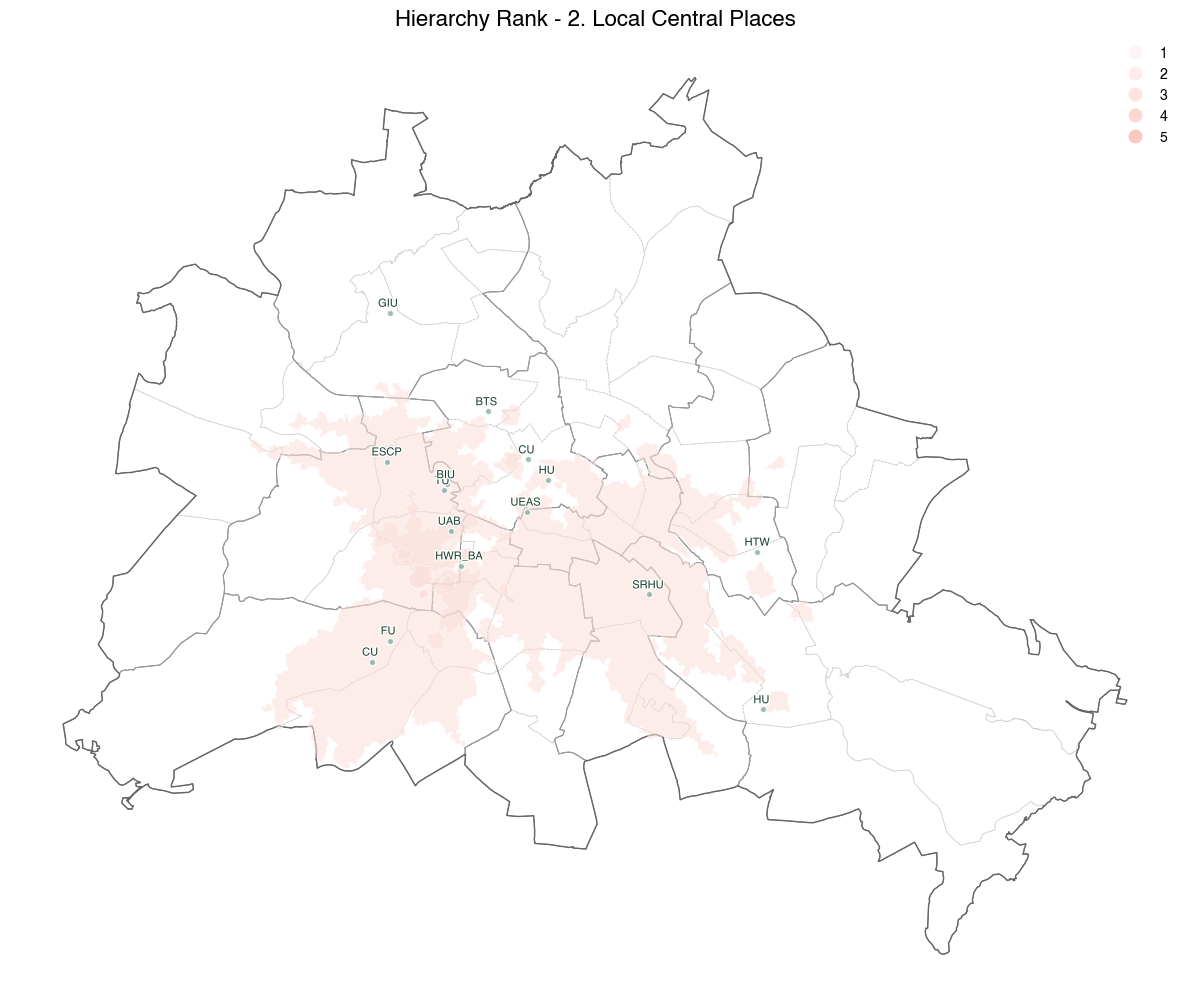

In [30]:
fig, axs  = plt.subplots(figsize=(12, 12))

pgr.plot(ax=axs, facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=axs, facecolor='none', edgecolor='#999999', linewidth=0.75)
out.plot(ax=axs, facecolor='none', edgecolor='#666666', linewidth=1)

market_area[market_area['cntr_hierarchy_rank'] == 2].plot(ax=axs,
          column='cntr_hierarchy_rank',
          cmap=cmap_pi,
          alpha=0.55,
          edgecolor='none',
          linewidth=0.3,
          legend=True,
          legend_kwds={'frameon': False},
          label = 'hierarchy rank', 
          vmin=0,
          vmax=5)

market_area[market_area['cntr_hierarchy_rank'] == 2].plot(
    ax=axs,
    edgecolor='white',  # variable for colormap
    facecolor="none",        # transparent polygons  # edge colors from your column
    linewidth=0.3,
    alpha=1
)

central_places.plot(ax=axs,
           color='#76A79D', 
           markersize=20,
           #markersize= 10,
           alpha=0.75,
           edgecolor='white',
           linewidth=1)
for _, row in central_places.iterrows():
    offset = 3  # vertical offset in points
    axs.annotate(
        row['abr'],                           # abbreviation
        xy=(row.geometry.x, row.geometry.y),  # coords from the Point
        xytext=(0, offset),                   # lift the text a bit
        textcoords='offset points',
        color='#1b4332',
        fontsize=8,
        ha='center',
        va='bottom',
        alpha=1,
        zorder=6,
        path_effects=[
            path_effects.Stroke(linewidth=2, foreground='white'),
            path_effects.Normal()
        ]
    )

axs.set_title('Hierarchy Rank - 2. Local Central Places', fontsize=16, fontweight='bold')
axs.set_axis_off()
plt.tight_layout()

save_path = os.path.join(hf, "Hierarchy Rank - 2. Local Central Places.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()

*Figure XX. Local Central Places*

In [ ]:
market_area[market_area['cntr_hierarchy_rank'] == 3][["fname","!s_aus_sum", "centrality", "cntr_service_range", 'cntr_hierarchy', 'cntr_hierarchy_rank']].head(15).sort_values("cntr_hierarchy", ascending=False) 

*Table XX. Local Central Places*

**Hierarchy Rank - 1. Basic Service Areas** 

Basic Service Areas (Figure XX) are formed around the German International University Berlin (GIU), University of Applied Sciences for Technology, Economics Berlin (HTW) and Humboldt University of Berlin (HU). These universities are basic service centres whose role in the structure of central locations is primarily to provide fundamental educational functions and support peripheral parts of the urban system.

Geographically, these market areas are located mainly in the districts of Reinickendorf, Treptow-Köpenick and Lichtenberg. They are situated to the south-east and north-west of the secondary central places. This location emphasises their functional role as areas serving peripheral or poorly integrated parts of the city's educational space, acting as ‘edge’ centres in Berlin's polycentric structure.

Collectively, Basic Service Areas account for about 19% of international student demand — more than  tertiary central places. This indicates that even the most basic centres in the hierarchy play a significant role in the distribution of student mobility and the formation of market pressure, serving significant shares of both educational and housing demand in the periphery.

It is worth noting that two of the three universities forming this hierarchical level belong to the Low–High (LH) cluster, demonstrating low supply with higher regional demand. The third university is private and belongs to the High–Low (HL) cluster, reflecting the opposite dynamic: a high value at the facility level in an environment with relatively low values. This distribution of clusters shows that the basic market areas are characterised by strong heterogeneity in demand and supply, as well as varying levels of integration into existing educational clusters.

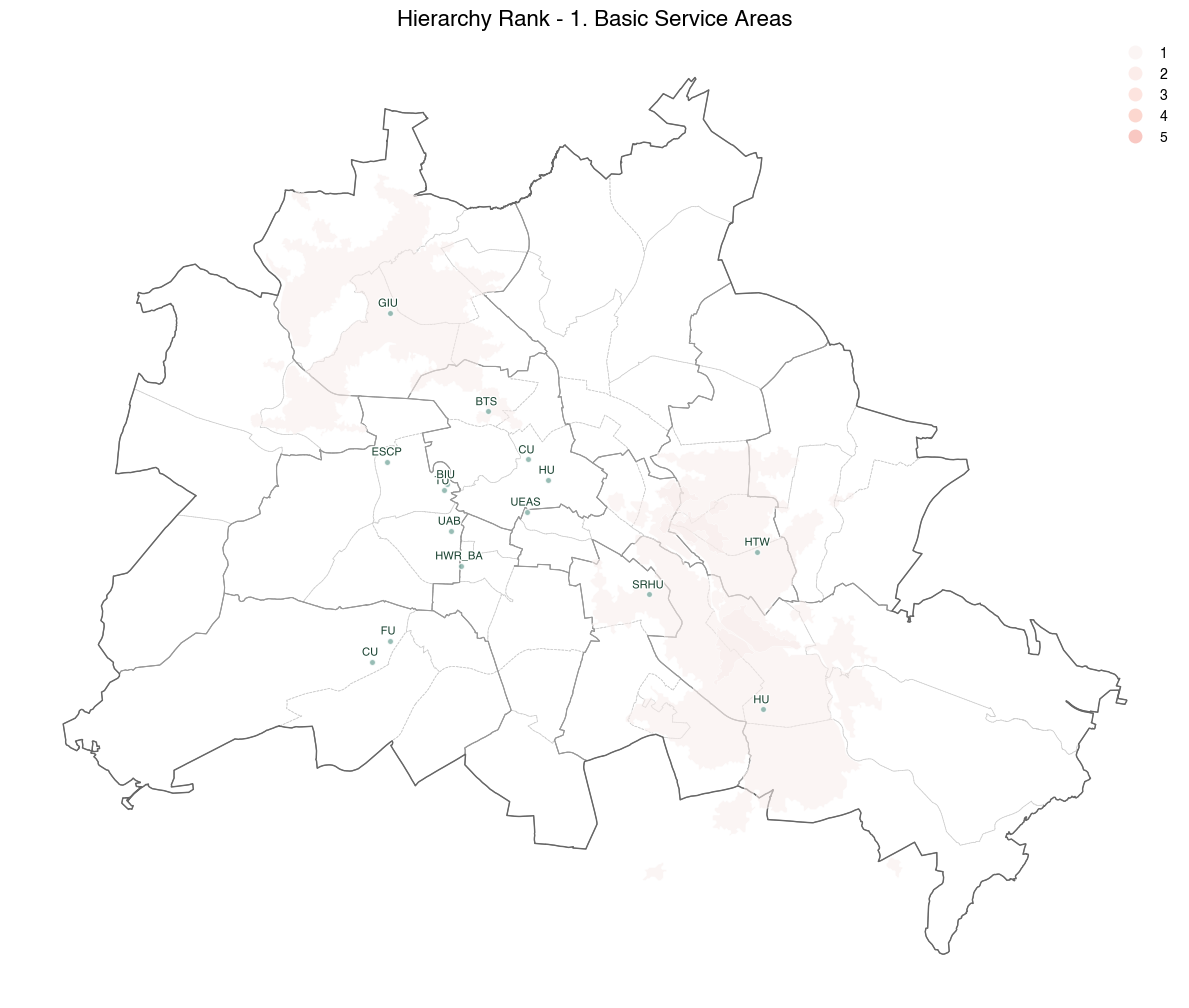

In [31]:
fig, axs  = plt.subplots(figsize=(12, 12))

pgr.plot(ax=axs, facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=axs, facecolor='none', edgecolor='#999999', linewidth=0.75)
out.plot(ax=axs, facecolor='none', edgecolor='#666666', linewidth=1)

market_area[market_area['cntr_hierarchy_rank'] == 1].plot(ax=axs,
          column='cntr_hierarchy_rank',
          cmap=cmap_pi,
          alpha=0.55,
          edgecolor='none',
          linewidth=0.3,
          legend=True,
          legend_kwds={'frameon': False},
          label = 'hierarchy rank', 
          vmin=0,
          vmax=5)

market_area[market_area['cntr_hierarchy_rank'] == 1].plot(
    ax=axs,
    edgecolor='white',  # variable for colormap
    facecolor="none",        # transparent polygons  # edge colors from your column
    linewidth=0.3,
    alpha=1
)

central_places.plot(ax=axs,
           color='#76A79D', 
           markersize=20,
           #markersize= 10,
           alpha=0.75,
           edgecolor='white',
           linewidth=1)
for _, row in central_places.iterrows():
    offset = 3  # vertical offset in points
    axs.annotate(
        row['abr'],                           # abbreviation
        xy=(row.geometry.x, row.geometry.y),  # coords from the Point
        xytext=(0, offset),                   # lift the text a bit
        textcoords='offset points',
        color='#1b4332',
        fontsize=8,
        ha='center',
        va='bottom',
        alpha=1,
        zorder=6,
        path_effects=[
            path_effects.Stroke(linewidth=2, foreground='white'),
            path_effects.Normal()
        ]
    )

axs.set_title('Hierarchy Rank - 1. Basic Service Areas', fontsize=16, fontweight='bold')
axs.set_axis_off()
plt.tight_layout()

save_path = os.path.join(hf, "Hierarchy Rank - 1. Basic Service Areas.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()

*Figure XX. Basic Service Areas*

In [ ]:
market_area[market_area['cntr_hierarchy_rank'] == 3][["fname","!s_aus_sum", "centrality", "cntr_service_range", 'cntr_hierarchy', 'cntr_hierarchy_rank']].head(15).sort_values("cntr_hierarchy", ascending=False) 

*Table XX. Basic Service Areas*

The constructed hierarchy of market areas revealed a pronounced polycentricity of the city's educational space: central locations at the highest levels concentrate the greatest student demand and form the main clusters of attraction, while lower-level zones perform supporting functions. At the same time, demand significantly exceeds supply at all levels.

Thus, the analysis shows that the student housing crisis in Berlin has a clearly defined spatial structure. The uneven distribution of both universities and accommodation infrastructure exacerbates market pressure, creating persistent areas of overload and local shortages, which require further strategic intervention and planning.

In [32]:
market_area.to_crs(epsg=25833)

ef = r"../outputs/3.2_central_place_analysis/market_area_central_place_analysis.gpkg"
market_area.to_file(ef, driver="GPKG")